<center><b><h1 style="font-size: value;"> Minimum Vertex Cover</h1></b>
Classical Approach vs Quantum QAOA Approach<br>
Using Networkx and Pennylane
</center>

### Outline:
1. Explaining the problem
2. Classical algorithm
3. Quantum QAOA algorithm
4. Questions
5. Exchange package: pennylane to openqasm
6. Exchange package: openqasm to qiskit
7. Exchange package: qiskit to qlm
8. Exchange package: qlm to cirq
9. Conclusion (package exchange)
10. References

### 1. Explaining the problem
<hr>

The "Minimum Vertex Cover Problem" is applied on undirected graphs to find the minimum set of vertices such that for any {u, v} edge present in the graph vertex u or v is included in the minimum vertex cover.

The following picture shows exaples of minimum vertex cover sets for different graphs.

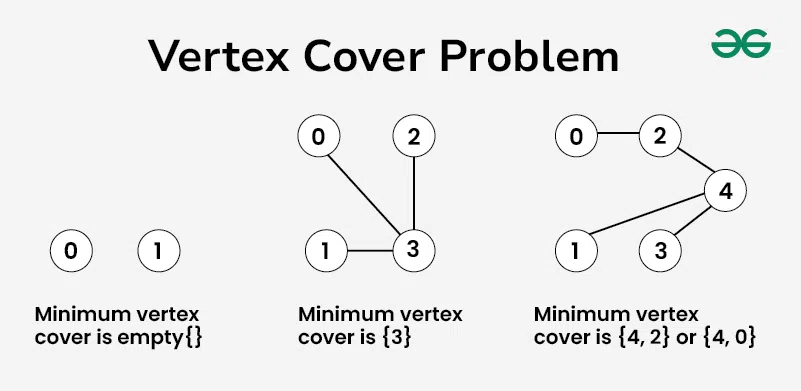
Image source: https://www.geeksforgeeks.org/introduction-and-approximate-solution-for-vertex-cover-problem/

### 2. Classical algorithm
<hr>

### cover is {}

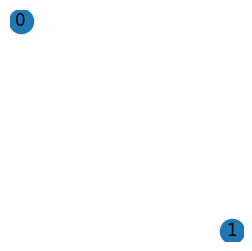

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G1 = nx.Graph()
G1.add_nodes_from([(0, {"color": "blue"}), (1, {"color": "blue"})])
fig, ax = plt.subplots(figsize=(3,3))
nx.draw(G1, with_labels=True, ax=ax)

Running the below commented code will give an error since the graph has no edges. So cover = {}

In [2]:
#matching1 = nx.bipartite.maximum_matching(G1)
#vertex_cover1 = nx.bipartite.to_vertex_cover(G1, matching)
#print(vertex_cover1)

### cover is {3}

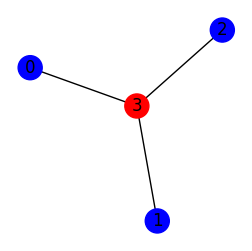

In [3]:
G2 = nx.Graph()
G2.add_nodes_from([(0, {"color": "blue"}), (1, {"color": "blue"}), (2, {"color": "blue"}), (3, {"color": "red"})])
G2.add_edges_from([(0, 3), (1, 3), (2, 3)])
default_color = 'blue'
colored_dict = nx.get_node_attributes(G2, 'color')
color_seq = [colored_dict.get(node, default_color) for node in G2.nodes()]
fig, ax = plt.subplots(figsize=(3,3))
nx.draw(G2, with_labels=True, ax=ax, node_color=color_seq)

In [4]:
matching2 = nx.bipartite.maximum_matching(G2)
vertex_cover2 = nx.bipartite.to_vertex_cover(G2, matching2)
print(vertex_cover2)

{3}


### cover is {0, 4} or {2, 4}

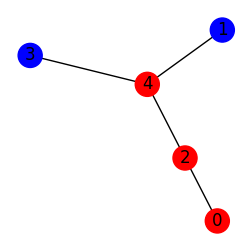

In [5]:
G3 = nx.Graph()
G3.add_nodes_from([(0, {"color": "red"}), (1, {"color": "blue"}), (2, {"color": "red"}), (3, {"color": "blue"}), (4, {"color": "red"})])
G3.add_edges_from([(0, 2), (2, 4), (1, 4), (3, 4)])
default_color = 'blue'
colored_dict = nx.get_node_attributes(G3, 'color')
color_seq = [colored_dict.get(node, default_color) for node in G3.nodes()]
fig, ax = plt.subplots(figsize=(3,3))
nx.draw(G3, with_labels=True, ax=ax, node_color=color_seq)

In [6]:
matching3 = nx.bipartite.maximum_matching(G3)
vertex_cover3 = nx.bipartite.to_vertex_cover(G3, matching3)
print(vertex_cover3)

{0, 4}


The classical solution is very helpful to be able to compare it with the quantum solution for these graphs and other graphs.

It is worth mentioning that although we have the solution for these graphs but for other graphs we might not, so using networkx will be of great help.

### 3. Quantum QAOA algorithm
<hr>

<center>$|\gamma ,\beta \rangle ={e}^{-i{\beta }_{p}B}{e}^{-i{\gamma }_{p}C}\ldots {e}^{-i{\beta }_{1}B}{e}^{-i{\gamma }_{1}C}|+\ldots +\rangle$</center>

The algorihm starts by building the ansatz which is built using the following steps:
<ol>
    <li>Start first in the $|+\ldots +\rangle$ state as shown in the equation above, by applying the H gate on all qubits.</li>
    <li>Apply the QAOA layer ${e}^{-i{\beta }_{p}B}{e}^{-i{\gamma }_{p}C}$ n-times, in which this layer will be explained later. </li>
    <li>Use a classical optimizer to minimize a cost function defined later in the code.</li>
</ol>

<ul>
    <li>Why do we need to repeat n-times?</li>
    The reason for that is that we want to apply $U(H, \ t) \ = \ e^{-i (H_{c}+H_{m}) t / \hbar} = \ e^{-i H_{c} t / \hbar} \ e^{-i H_{m} t / \hbar}$. But to apply the time evolution $U$ gate using the right hand side of the equality equation, both $H_{c}$ and $H_{m}$ should commute but this is not our case so we use the "ApproxTimeEvolution()" pennylane function.
    <li>How big should n be?</li>
    The higher the value of n the better and more accurate the results will be, so the choice of n depends on how much accurate the results should be and how much computational resources are available.
    <li>What does the QAOA layer contain?</li>
    This layer contains what we call the mixer and cost hamiltonians.
    The mixer is used to put the states in superposition to allow the algorithm to explore several solutions.
    The cost hamiltonian encodes the cost function.
    <li>What does the optimizer do?</li>
    The optimizer updates the parameters in the circuit to minimize the encoded cost function, by other words finding the ground state of $H_{c}$ .
</ul>

In [7]:
from pennylane import qaoa
from pennylane import numpy as np

Happily, pennylane QAOA has builtin functions for some problems like "Vertex Cover", we can use the following cell to find the mixer and cost hamiltonian. We will focus on G3 graph.

In [8]:
cost_h, mixer_h = qaoa.min_vertex_cover(G3, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.75 * (Z(0) @ Z(2)) + 0.75 * Z(0) + 0.75 * Z(2) + 0.75 * (Z(1) @ Z(4)) + 0.75 * Z(1) + 0.75 * Z(4) + 0.75 * (Z(2) @ Z(4)) + 0.75 * Z(2) + 0.75 * Z(4) + 0.75 * (Z(3) @ Z(4)) + 0.75 * Z(3) + 0.75 * Z(4) + -1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3) + -1.0 * Z(4)
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3) + 1 * X(4)


We now define the layer that will be repeated n times

In [9]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

Since we have 5 vertices, we need to use 5 qubits.
Since we will be using $n=2$ then we will use 2 params, params[0] and params[1] .

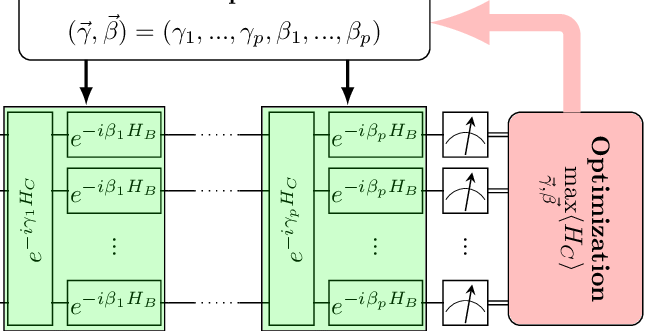
Image source: https://www.researchgate.net/figure/The-routine-of-the-Quantum-Approximate-Optimization-Algorithm-QAOA_fig1_353838416

In [10]:
wires = range(5)
n = 2


def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, n, params[0], params[1])

Now we define our cost function which will be minimized by the optimizer.

Since we need to find the ground state energy of the hamiltonian, which is the lowest energy, then we need to minimize the expectation value(energy) of the hamiltonian.

It is worth mentioning that we need to minimize $H_{c}$ expectation value since it encodes the cost function we want to minimize.

In [11]:
import pennylane as qml
dev = qml.device("default.qubit", wires=wires)


@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

Now we specify our optimizer, in our case Adam, and the initial starting parameters.

In [12]:
optimizer = qml.AdamOptimizer()
steps = 400
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

In [13]:
for i in range(steps):
    params, cost = optimizer.step_and_cost(cost_function, params)
    if i%10 == 0:
        print(f"Iteration: {i}, cost: {cost}")

Iteration: 0, cost: 1.5658670030768582
Iteration: 10, cost: 0.6566083642414431
Iteration: 20, cost: -0.15599586153249304
Iteration: 30, cost: -0.690179225445285
Iteration: 40, cost: -0.9460414571345099
Iteration: 50, cost: -1.0035414853698743
Iteration: 60, cost: -1.0187706151110318
Iteration: 70, cost: -1.019866897241933
Iteration: 80, cost: -1.0216194106102923
Iteration: 90, cost: -1.0217076500265172
Iteration: 100, cost: -1.0217262330914254
Iteration: 110, cost: -1.021875827393288
Iteration: 120, cost: -1.0219089249650364
Iteration: 130, cost: -1.0219170149365566
Iteration: 140, cost: -1.0219218024211614
Iteration: 150, cost: -1.021921936743565
Iteration: 160, cost: -1.0219228618131337
Iteration: 170, cost: -1.0219235319142543
Iteration: 180, cost: -1.0219241109066548
Iteration: 190, cost: -1.0219246685178418
Iteration: 200, cost: -1.0219252538644106
Iteration: 210, cost: -1.021925877140334
Iteration: 220, cost: -1.0219265350582276
Iteration: 230, cost: -1.0219272328881877
Iteration

We can clearly see that the cost function converges slowly around -1.0219 which shows that our minimum cost is around this value.

In [14]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

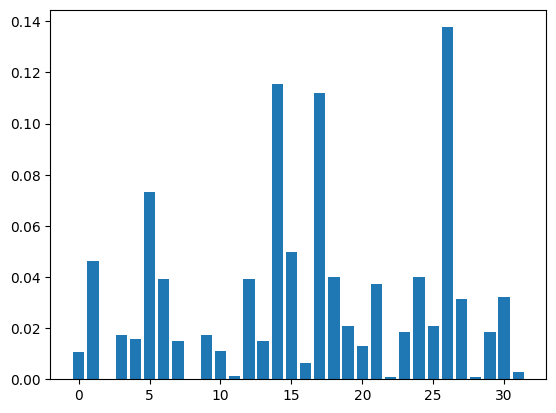

In [15]:
plt.bar(range(2 ** len(wires)), probs)
plt.show()

What differes the quantum solution from the classical solution is that the quantum one gives several solutions with a probability instead of only one solution.

We got 3 solutions having near probabilities:
<ul>
    <li>prob: 0.14, $|26\rangle \ = \ |11010\rangle$, 0-1-3</li>
    <li>prob: 0.12, $|14\rangle \ = \ |01110\rangle$, 1-2-3</li>
    <li>prob: 0.11, $|17\rangle \ = \ |10001\rangle$, 0-4</li>
</ul>

We can conclude that out of the 3 values with near high probability 2 values were incorrect and the value of $|17\rangle \ = \ |10001\rangle$, which gave 0-4 was correct. We should remention that the correct values are 0-4 or 2-4.

### Questions:
<hr>
<ul>
    <li>How much increase in the value of n is required to reach the correct results?</li>
    <li>What is the least value of iterations to reach the local minima(minimized cost)?</li>
    <li>How will QAOA work for other graphs?</li>
</ul>

### Exchange package: pennylane to openqasm
<hr>

We do first need to define the circuit with some modifications:
<ul>
    <li>Each circuit node in pennylane should return something so we return expectation on identity gate first qubit, instead of the operator expectation value. After changing to qiskit, the operator can be used in the cost function.</li>
    <li>The used package for exchanging does not support pennylane so we need to change to openqasm and then from openqasm to qiskit and other languages.</li>
    <li>We need to define the circuit as Qnode and not as before defining the cost function as Qnode.</li>
</ul>

In [16]:
wires = range(5)
n = 2
import pennylane as qml

dev = qml.device("default.qubit", wires=wires)


@qml.qnode(dev)
def circuit(params):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, n, params[0], params[0])
    return qml.expval(qml.Identity(0))

One extra thing before transforming to openqasm is tht we need to construct the circuit with the parameters values.

In [19]:
parameters = np.array([[0.5, 0.5]], requires_grad=True)
circuit.construct([parameters], {})

Now we can transform to open qasm

In [20]:
qasm_circuit = circuit.qtape.to_openqasm()
qasm_circuit

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[5];\ncreg c[5];\nh q[0];\nh q[1];\nh q[2];\nh q[3];\nh q[4];\ncx q[2],q[0];\nrz(0.75) q[0];\ncx q[2],q[0];\nrz(-0.25) q[0];\nrz(0.5) q[2];\ncx q[4],q[1];\nrz(0.75) q[1];\ncx q[4],q[1];\nrz(-0.25) q[1];\nrz(1.25) q[4];\ncx q[4],q[2];\nrz(0.75) q[2];\ncx q[4],q[2];\ncx q[4],q[3];\nrz(0.75) q[3];\ncx q[4],q[3];\nrz(-0.25) q[3];\nh q[0];\nrz(1.0) q[0];\nh q[0];\nh q[1];\nrz(1.0) q[1];\nh q[1];\nh q[2];\nrz(1.0) q[2];\nh q[2];\nh q[3];\nrz(1.0) q[3];\nh q[3];\nh q[4];\nrz(1.0) q[4];\nh q[4];\ncx q[2],q[0];\nrz(0.75) q[0];\ncx q[2],q[0];\nrz(-0.25) q[0];\nrz(0.5) q[2];\ncx q[4],q[1];\nrz(0.75) q[1];\ncx q[4],q[1];\nrz(-0.25) q[1];\nrz(1.25) q[4];\ncx q[4],q[2];\nrz(0.75) q[2];\ncx q[4],q[2];\ncx q[4],q[3];\nrz(0.75) q[3];\ncx q[4],q[3];\nrz(-0.25) q[3];\nh q[0];\nrz(1.0) q[0];\nh q[0];\nh q[1];\nrz(1.0) q[1];\nh q[1];\nh q[2];\nrz(1.0) q[2];\nh q[2];\nh q[3];\nrz(1.0) q[3];\nh q[3];\nh q[4];\nrz(1.0) q[4];\nh q[4];\nmeasure q[0] -> c[0];\nmeasure

The problem is that by using construct, which is essential, our circuit is no more parameterized and the parameters have fixed values. But, this is because pennylane is not supported by myQLM library and the pennylane function cannot handle parameterized gates with unkown values. Happily, if we start from qiskit going to the qlm language then to cirq in which all the 3 supported by myQLM library, we can still have parameterized gates. 

### Exchange package: openqasm to qiskit
<hr>

Saving the openqasm code in a file

In [21]:
file = open('qasmCircuit.txt', 'w') 
file.write(qasm_circuit) 
file.close() 

Building the qiskit circuit from the openqasm saved file

In [24]:
import qiskit
from qiskit import *
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
qc = QuantumCircuit.from_qasm_file('qasmCircuit.txt')

C:\Users\lenovo\anaconda3\envs\openvqe3\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


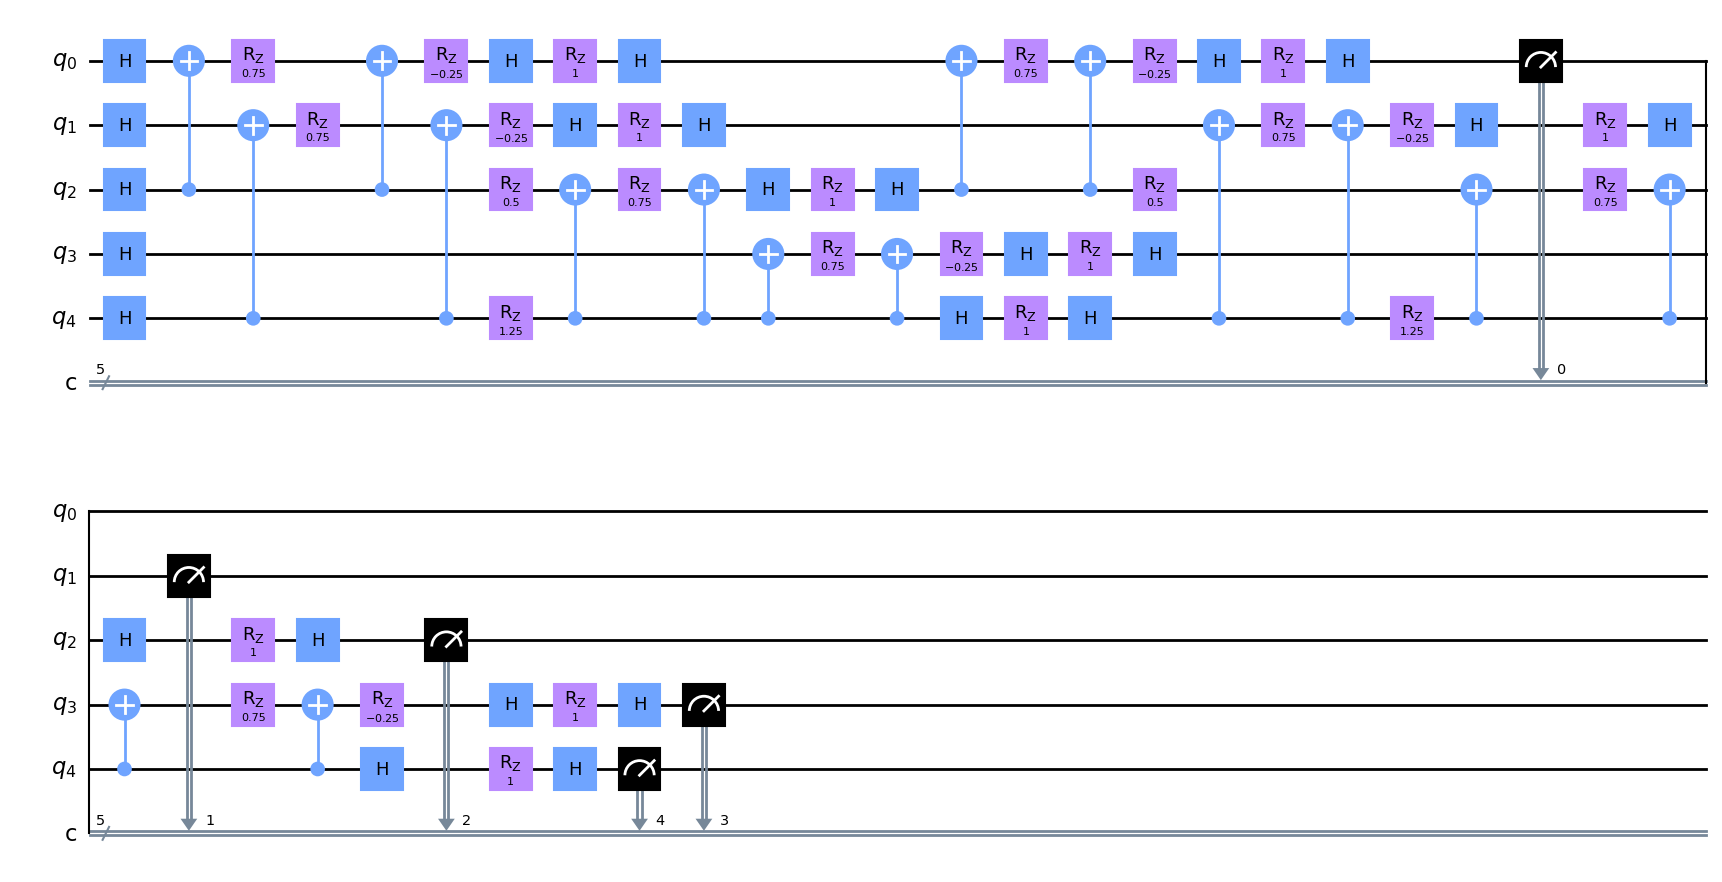

In [23]:
qc.draw('mpl')

What if we had a parameterized qiskit quantum circuit? We can still convert to qlm and cirq preserving parameterized gates without having there parameters fixed or unparameterized.

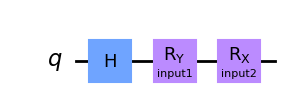

In [25]:
params1 = [Parameter("input1"), Parameter("input2")]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc1.draw("mpl", style="clifford")

In the next parts we will convert both circuits qc and qc1 into qlm and cirq circuits

### Exchange package: qiskit to qlm
<hr>

We will convert first the circuit we got from pennylane(which was in the previous cell transformed into qiskit circuit)

In [38]:
from qat.lang import *
from qat import *
from qat.interop.qiskit import qiskit_to_qlm

qlm_circuit = qiskit_to_qlm(qc)

In [39]:
qlm_circuit().display()

Now we transform the parameterized circuit obtained from qiskit into a qlm circuit.

In [40]:
qlm_circuit1 = qiskit_to_qlm(qc1)
qlm_circuit1.get_variables()

['input1', 'input2']

We can see that it was successfullly transformed and it now has 2 parameterized inputs/gates.

In [41]:
 qlm_circuit1().display()

Additionally to printing the circuit we can also print the gates.

In [42]:
for gate in qlm_circuit1.iterate_simple():
    print(gate)

('H', [], [0])
('RY', [<qat.core.variables.Variable object at 0x000002556D963C50>], [0])
('RX', [<qat.core.variables.Variable object at 0x000002556D963260>], [0])


### Exchange package: qlm to cirq
<hr>

Now we start by transforming the unparameterized qlm circuit into a cirq circuit.

In [43]:
from qat.interop.cirq import qlm_to_cirq
cirq_circuit = qlm_to_cirq(qlm_circuit)

In [44]:
print(cirq_circuit)

          ┌──┐                ┌──┐                                                                                                 ┌───────────┐
1: ───H────X─────Rz(0.239π)────X─────Rz(-0.08π)───H───Rz(0.318π)───H────────────────────────X────────────Rz(0.239π)───X─────────────Rz(-0.08π)─────H────────────Rz(0.318π)───H────────────M───M────────────────────────────────────────────────────────────────────────────────────────
           │                   │                                                            │                         │
2: ───H────┼X────Rz(0.239π)────┼X────Rz(-0.08π)───H───Rz(0.318π)───H────────────────────────┼─────────────────────────┼───────────────────────X────Rz(0.239π)───X────────────Rz(-0.08π)───H───Rz(0.318π)───H───M───M───────────────────────────────────────────────────────────────────
           ││                  ││                                                           │                         │                       │                 │
3: ───H────@┼

After finishing successfully the transformation of the first ciruit, the next cells show the successfull transformation of the parameterized circuit into a cirq circuit.

In [45]:
cirq_circuit1 = qlm_to_cirq(qlm_circuit1)

In [46]:
print(cirq_circuit1)

1: ───H───Ry(input1)───Rx(input2)───M───


### Conclusion (package exchange):
<hr>

We can see the following conclusions from the past code:
<ul>
    <li>We have 2 ways for package exchanges of circuits: using myQLM library or transforming pennylane circuit to openqasm then to qiskit.</li>
    <li>By using myQLM we preserve the parameterized gates as parameterized, while by using pennylane to openqasm these gates are not preserved.</li>
    <li>We can transform circuits between 3 to 4 different quantum programming languages: Pennylane, Qiskit, Qlm and Cirq.</li>
</ul>

### References:
<hr>
<ol>
    <li>Networkx vertex cover function: <a href="https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.matching.to_vertex_cover.html">link</a></li>
    <li>Geeks for Geeks vertex cover explanation: <a href="https://www.geeksforgeeks.org/introduction-and-approximate-solution-for-vertex-cover-problem/">link</a></li>
    <li>StackOverflow building and coloring networkx graphs: <a href="https://stackoverflow.com/questions/63565116/adding-color-to-edges-or-nodes-doesnt-work-in-networkx">link</a></li>
    <li>QAOA for max-cut: <a href="https://www.nature.com/articles/s41598-019-43176-9">link</a></li>
    <li>What is a mixer hamiltonian? <a href="https://library.fiveable.me/key-terms/quantum-machine-learning/mixer-hamiltonian">link</a></li>
    <li>Decimal to binary conversion: <a href="https://www.rapidtables.com/convert/number/decimal-to-binary.html?x=17">link</a></li>
    <li>Pennylane unitary time evolution: <a href="https://docs.pennylane.ai/en/stable/code/api/pennylane.ApproxTimeEvolution.html">link</a></li>
    <li>Pennylane QAOA Tutorial: <a href="https://pennylane.ai/qml/demos/tutorial_qaoa_intro/">link</a></li>
    <li>QAOA routine: <a href="https://www.researchgate.net/figure/The-routine-of-the-Quantum-Approximate-Optimization-Algorithm-QAOA_fig1_353838416">link</a></li>
</ol>